In [65]:
import pandas as pd
from java_migration.eval.smol_log_parser import parse_log
from pathlib import Path
import numpy as np
from java_migration.eval.utils import recover_safe_repo_name
import yaml
import pandas as pd
import seaborn as sns

from collections.abc import MutableMapping


def flatten(dictionary, parent_key="", separator="_"):
    items = []
    for key, value in dictionary.items():
        new_key = parent_key + separator + key if parent_key else key
        if isinstance(value, MutableMapping):
            items.extend(flatten(value, new_key, separator=separator).items())
        else:
            items.append((new_key, value))
    return dict(items)

In [27]:
duration = [np.sum([y.meta.duration for y in x.steps]) for x in agent_logs]

[np.float64(41.010000000000005),
 np.float64(98.6),
 np.float64(113.87),
 np.float64(41.120000000000005),
 np.float64(307.15000000000003),
 np.float64(158.61999999999998),
 np.float64(278.40999999999997),
 np.float64(262.92),
 np.float64(57.01),
 np.float64(317.76),
 np.float64(62.449999999999996),
 np.float64(49.230000000000004),
 np.float64(483.93),
 np.float64(98.78999999999999)]

In [46]:
def get_experiment_data(experiment_path):
    exp_dirs = [Path(f.path) for f in os.scandir(experiment_path / "job_results") if f.is_dir()]
    repo_names = [recover_safe_repo_name(f.name) for f in exp_dirs]

    repo_dict = {repo_name: {} for repo_name in repo_names}

    for exp_dir, repo_name in zip(exp_dirs, repo_names):
        if (exp_dir / "stdout.log").exists():
            repo_dict[repo_name]["agent_log"] = parse_log(open(exp_dir / "stdout.log").read())
        if (exp_dir / "result.yaml").exists():
            with open(exp_dir / "result.yaml") as fin:
                repo_dict[repo_name]["build_result"] = yaml.safe_load(fin.read())

    return repo_dict


exp_data = get_experiment_data(experiment_path)

In [62]:
def get_experiment_features(exp_data):
    exp_feats = []
    for repo_name, repo_data in exp_data.items():
        cur_feats = {"repo_name": repo_name}
        if "build_result" in repo_data and repo_data["build_result"] is not None:
            cur_feats.update(flatten(repo_data["build_result"]))
        exp_feats.append(cur_feats)
        if "agent_log" in repo_data:
            cur_feats["run_duration"] = np.sum([y.meta.duration for y in repo_data["agent_log"].steps])
            cur_feats["input_tokens"] = np.sum([y.meta.input_tokens for y in repo_data["agent_log"].steps])
            cur_feats["output_tokens"] = np.sum([y.meta.input_tokens for y in repo_data["agent_log"].steps])
            cur_feats["num_steps"] = len(repo_data["agent_log"].steps)
    return exp_feats


exp_features = get_experiment_features(exp_data)
df = pd.DataFrame(exp_features)

<Axes: >

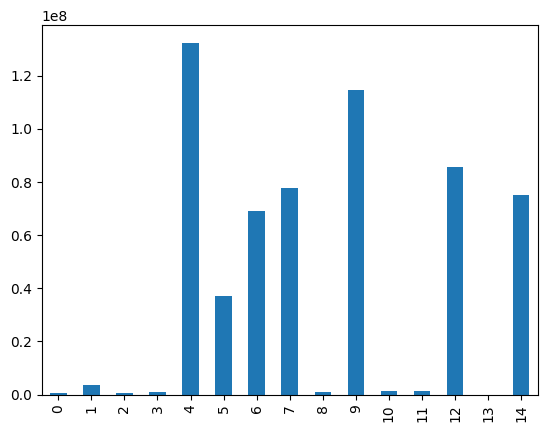

In [66]:
df.input_tokens.plot(kind="bar")